# LUME-Impact Basics

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Nicer plotting
import matplotlib.pyplot as plt
import matplotlib
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

In [2]:
from impact import Impact

Point to a valid input file

In [3]:
ifile = 'templates/lcls_injector/ImpactT.in'

Make Impact object

In [4]:
I = Impact(ifile, verbose=True)

Configured to run in: /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmp8m1a68h4


Change some things

In [5]:
I.header['Np'] = 10000
I.header['Nx'] = 16
I.header['Ny'] = 16
I.header['Nz'] = 16
I.header['Dt'] = 5e-13

# Turn Space Charge off. Both these syntaxes work
I.header['Bcurr'] = 0 
I['header:Bcurr'] = 0 

# Other switches
I.timeout = None

# Switches for MPI
I.numprocs = 4

# This is equivalent to:
#I.use_mpi=True
#I.header['Nprow'] = 2
#I.header['Npcol'] = 2



Setting Npcol, Nprow = 2, 2
Enabling MPI


Plot the layout.

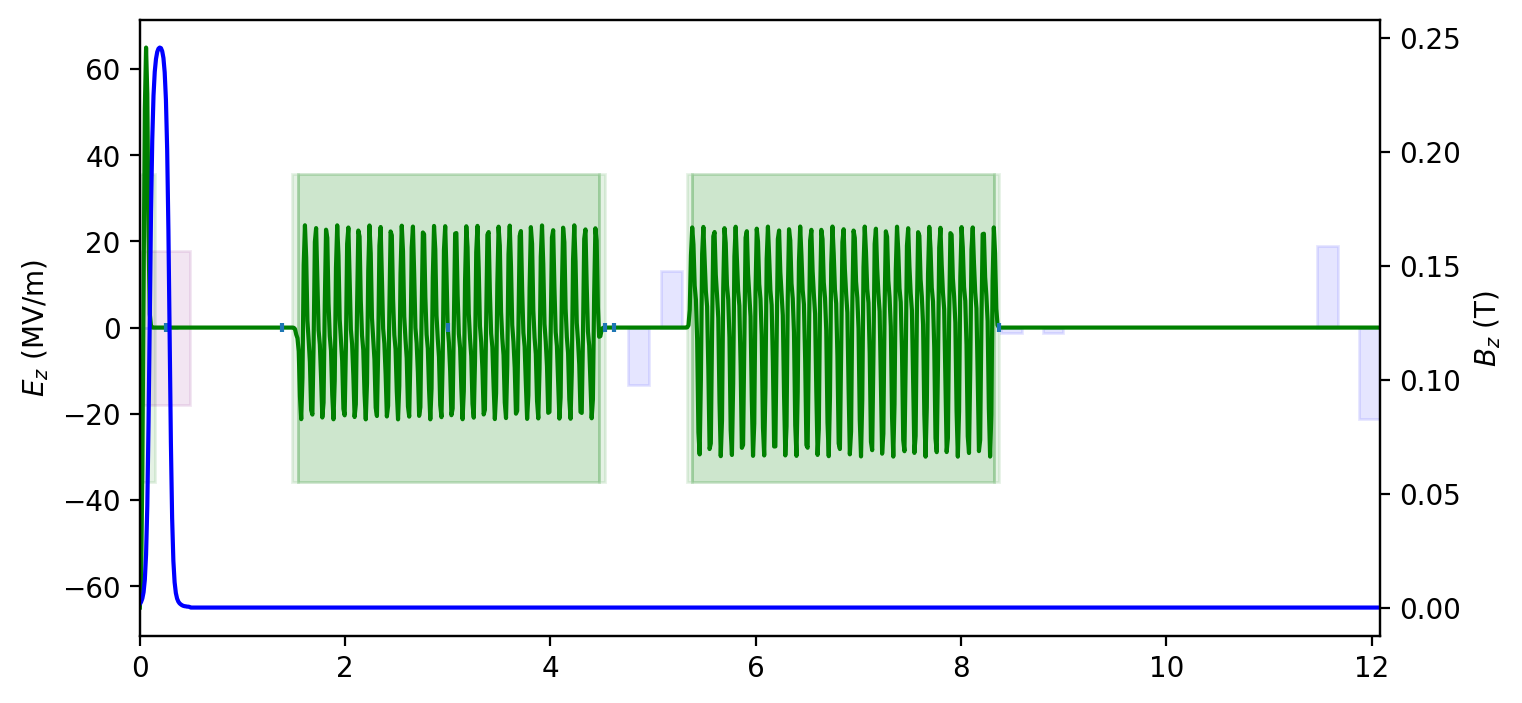

In [6]:
I.plot()

Change stop location. Here this is does the same as `I.ele['stop_1']['s'] = 1.5`.

In [7]:
I.stop = 1.5

Removed element: stop_1
Set stop to s = 1.5


Run Impact-T. This automatically finds the appropriate executable.

In [8]:
I.run()

Running Impact-T in /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmp8m1a68h4
mpirun -n 4 /Users/chrisonian/Code/Impact/IMPACT-T/build-mpi/ImpactTexe-mpi
 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code: 2.1 beta version
 ! Copyright of The Regents of the University of California
 !-----------------------------------------------------------
 nblem:           28          28
 pass setting up lattice...
 check randomness:            0  0.30440529327431320     
 check randomness:            1  0.83543324059415791     
 check randomness:            2  0.66382677037082638     
 check randomness:            3  0.69219578710848950     
 avgpts, jlow, and jhigh:         2500           1        2500
 avgpts, jlow, and jhigh:         2500        2501        5000
 avgpts, jlow, and jhigh:         2500        5001        7500
 avgpts, jlow, and jhigh:         2500        7501       10000
 before  destruct4:, elapsed: 6.751051902770996

Plot now shows the output statistics.

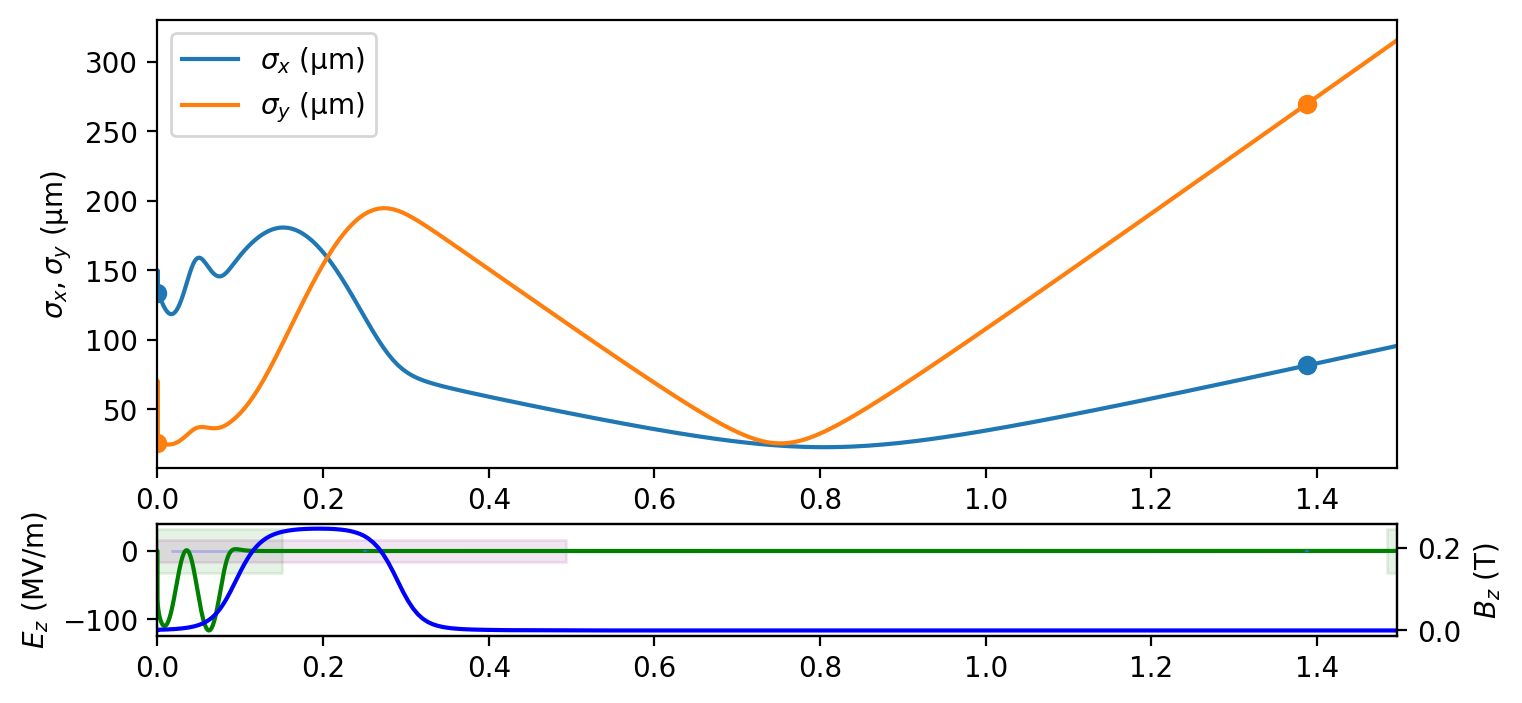

In [9]:
I.plot()
#plt.savefig('../assets/plot.png', dpi=150)

These are used to create the input.

In [10]:
I.input.keys()

dict_keys(['original_input', 'input_particle_file', 'header', 'lattice', 'fieldmaps'])

This is the output parsed

In [11]:
I.output.keys()

dict_keys(['run_info', 'stats', 'slice_info', 'particles'])

stats from the various fort. files

In [12]:
I.output['stats'].keys()

dict_keys(['t', 'mean_z', 'moment4_x', 'moment4_y', 'moment4_z', 'mean_y', 'sigma_y', 'norm_emit_y', 'mean_x', 'sigma_x', 'norm_emit_x', 'sigma_z', 'norm_emit_z', 'loadbalance_min_n_particle', 'loadbalance_max_n_particle', 'n_particle', 'moment3_x', 'moment3_y', 'moment3_z', 'mean_gamma', 'mean_beta', 'max_r', 'sigma_gamma', 'max_amplitude_x', 'max_amplitude_y', 'max_amplitude_z', 'moment4_px', 'moment4_py', 'moment4_pz', 'mean_py', 'sigma_py', 'cov_y__py', 'mean_px', 'sigma_px', 'cov_x__px', 'mean_pz', 'sigma_pz', 'cov_z__pz', 'moment3_px', 'moment3_py', 'moment3_pz', 'mean_kinetic_energy', 'max_amplitude_px', 'max_amplitude_py', 'max_amplitude_pz'])

Slice info

In [13]:
I.output['slice_info'].keys()

dict_keys(['final_particle_slices', 'initial_particle_slices'])

# Particles

Particles are automatically parsed in to openpmd-beamphysics ParticleGroup objects

In [14]:
I.output['particles']

{'initial_particles': <ParticleGroup with 10000 particles at 0x12d743640>,
 'final_particles': <ParticleGroup with 10000 particles at 0x12d743400>,
 'YAG02': <ParticleGroup with 10000 particles at 0x12d7433d0>}

`I.particles` points to this. Get the final particles and calculate some statistics:

In [15]:
P = I.particles['final_particles']
P['mean_energy']

5996955.348819707

Show the units:

In [16]:
P.units('mean_energy')

pmd_unit('eV', 1.602176634e-19, (2, 1, -2, 0, 0, 0, 0))

`ParticleGroup` has built-in plotting

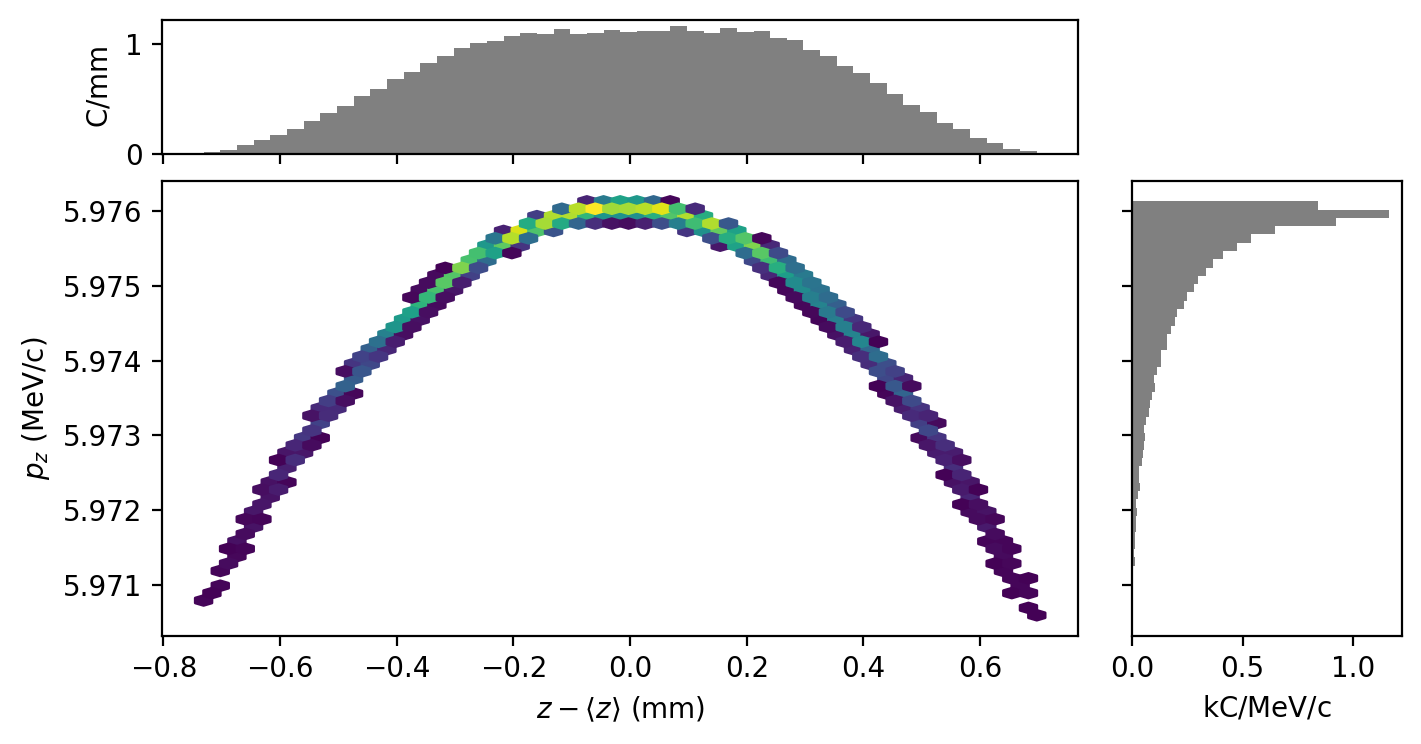

In [17]:
P.plot('delta_z', 'pz')
#plt.savefig('../assets/zpz.png', dpi=150)

# Stats

Impact's own calculated statistics can be retieved

In [18]:
 len(I.stat('norm_emit_x')), I.stat('norm_emit_x')[-1]

(631, 3.5584349e-08)

Stats can also be computed from the particles. For example:

In [19]:
I.particles['final_particles']['norm_emit_x']

3.5580305994129105e-08

Compare these:

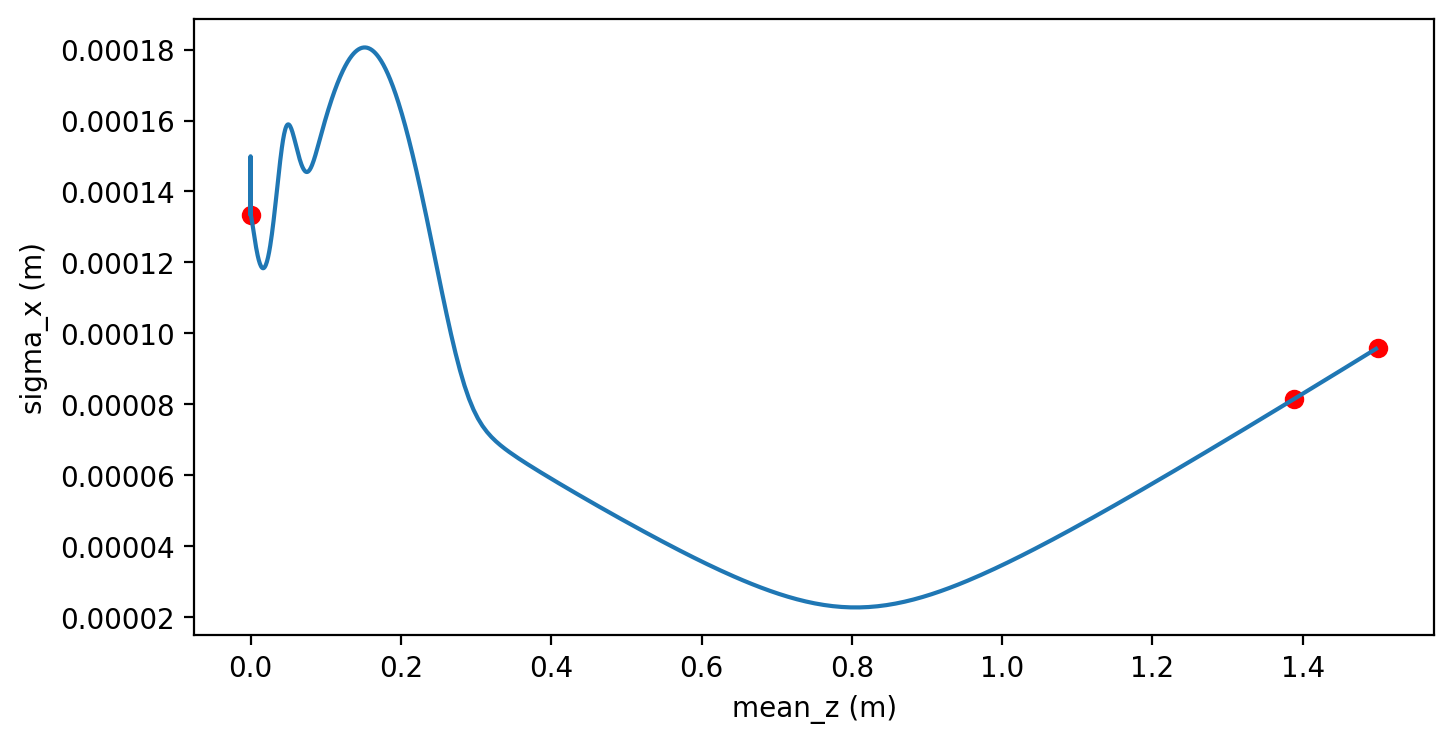

In [20]:
key1 = 'mean_z'
key2 = 'sigma_x'
units1 = str(I.units(key1))
units2 = str(I.units(key2))
plt.xlabel(key1+f' ({units1})')
plt.ylabel(key2+f' ({units2})')
plt.plot(I.stat(key1), I.stat(key2))
plt.scatter(
    [I.particles[name][key1] for name in I.particles], 
    [I.particles[name][key2] for name in I.particles], color='red')

This kind of plot is built-in for convenience, with a layout:

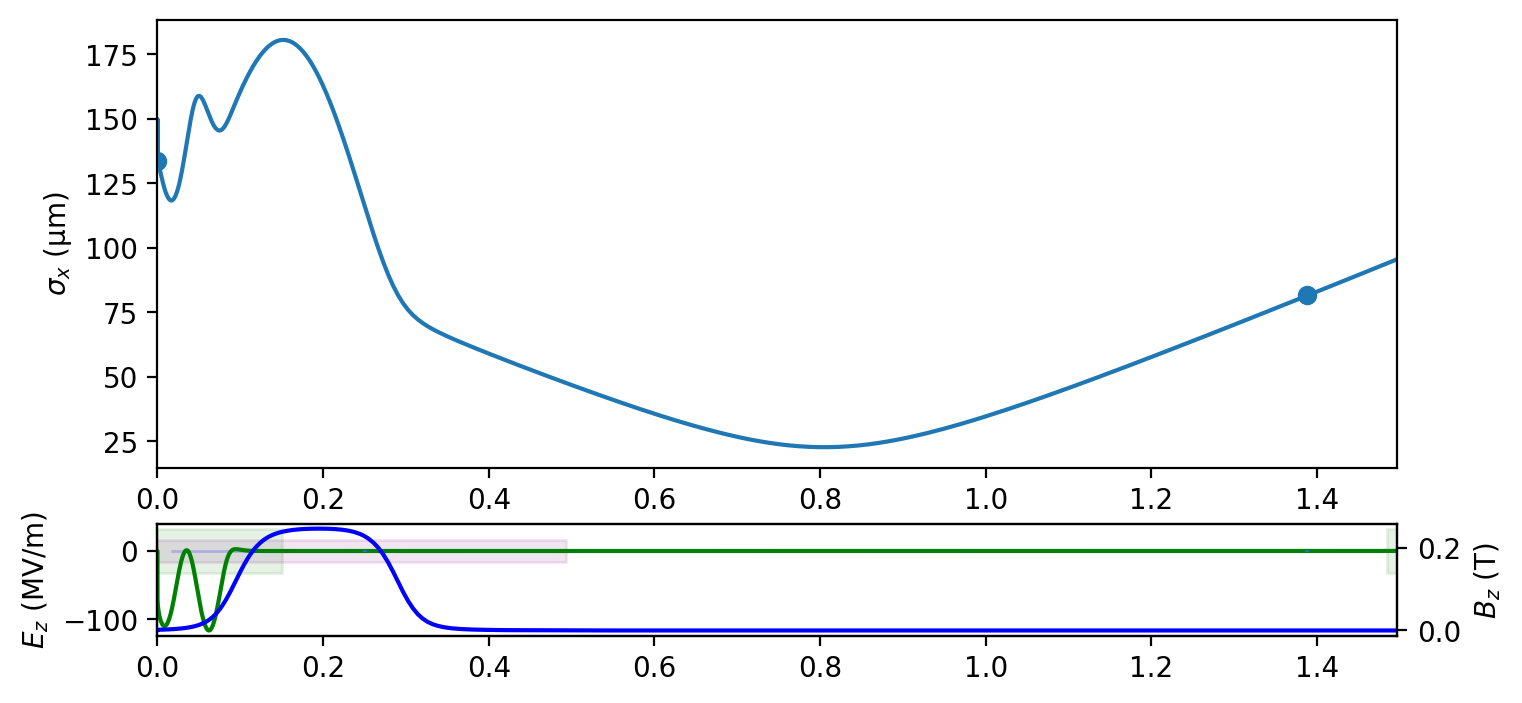

In [21]:
I.plot('sigma_x')

Even fancier options, and sending some options to matplotlib:

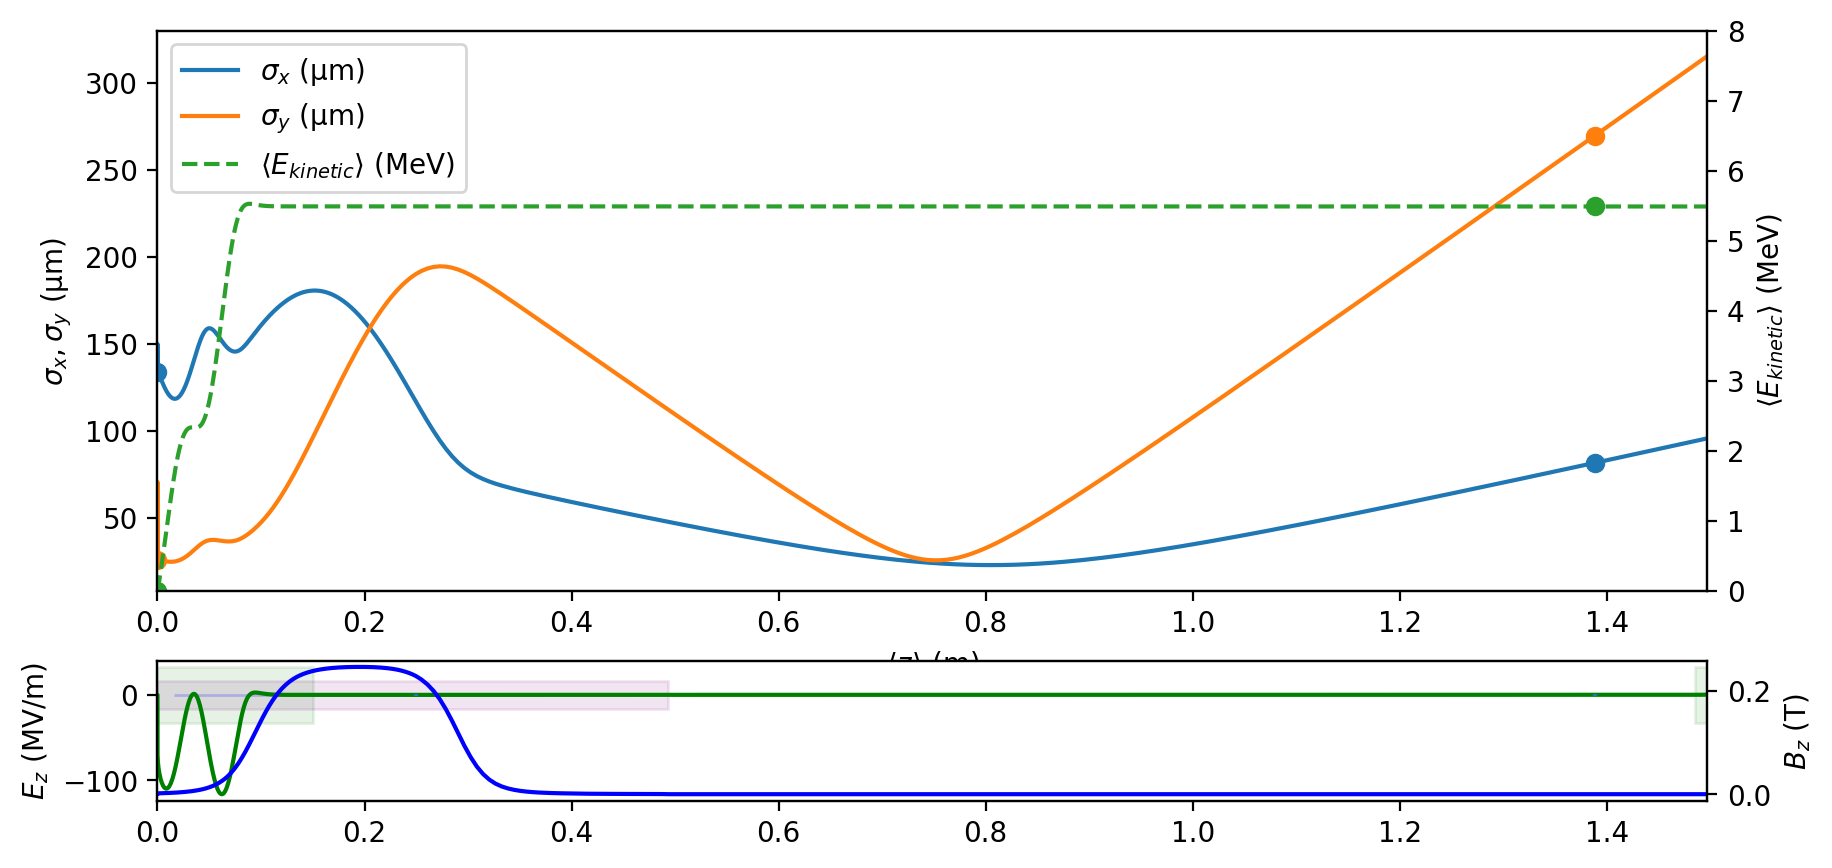

In [22]:
I.plot(['sigma_x', 'sigma_y'], y2=['mean_kinetic_energy'], ylim2=(0, 8e6), figsize=(10,5), include_field=True)

# Partial tracking

Particles can be started anywhere in the lattice. Here we will take some intermediate particles, and re-track. 

Get particles at the `YAG02` marker:

In [23]:
Pmid = I.particles['YAG02']

Make a copy, so that the previous object is preserved. 

In [24]:
I2 = I.copy()
I.verbose=False

The copy needs to be configured before tracking

In [25]:
I2.configure()

Configured to run in: /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpu3dlnadu


Track to 2 m

In [26]:
Pfinal = I2.track(Pmid, 2.0)

Removed element: stop_1
Set stop to s = 2.0
Running Impact-T in /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpu3dlnadu
mpirun -n 4 /Users/chrisonian/Code/Impact/IMPACT-T/build-mpi/ImpactTexe-mpi
Some initial particles z !=0, disabling cathode_start
writing 10000 particles to /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpu3dlnadu/partcl.data
Normal start with at time 4.668266808111253e-09 s
Normal start: Replaced Np with 10000 according to initial particles
Normal start: Replaced Tini with 4.668266808111253e-09 according to initial particles
Normal start: Replaced Flagimg with 0 according to initial particles
 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code: 2.1 beta version
 ! Copyright of The Regents of the University of California
 !-----------------------------------------------------------
 nblem:           28          28
 pass setting up lattice...
 check randomness:            0  0.30440529327431320     
 c

Compare these:

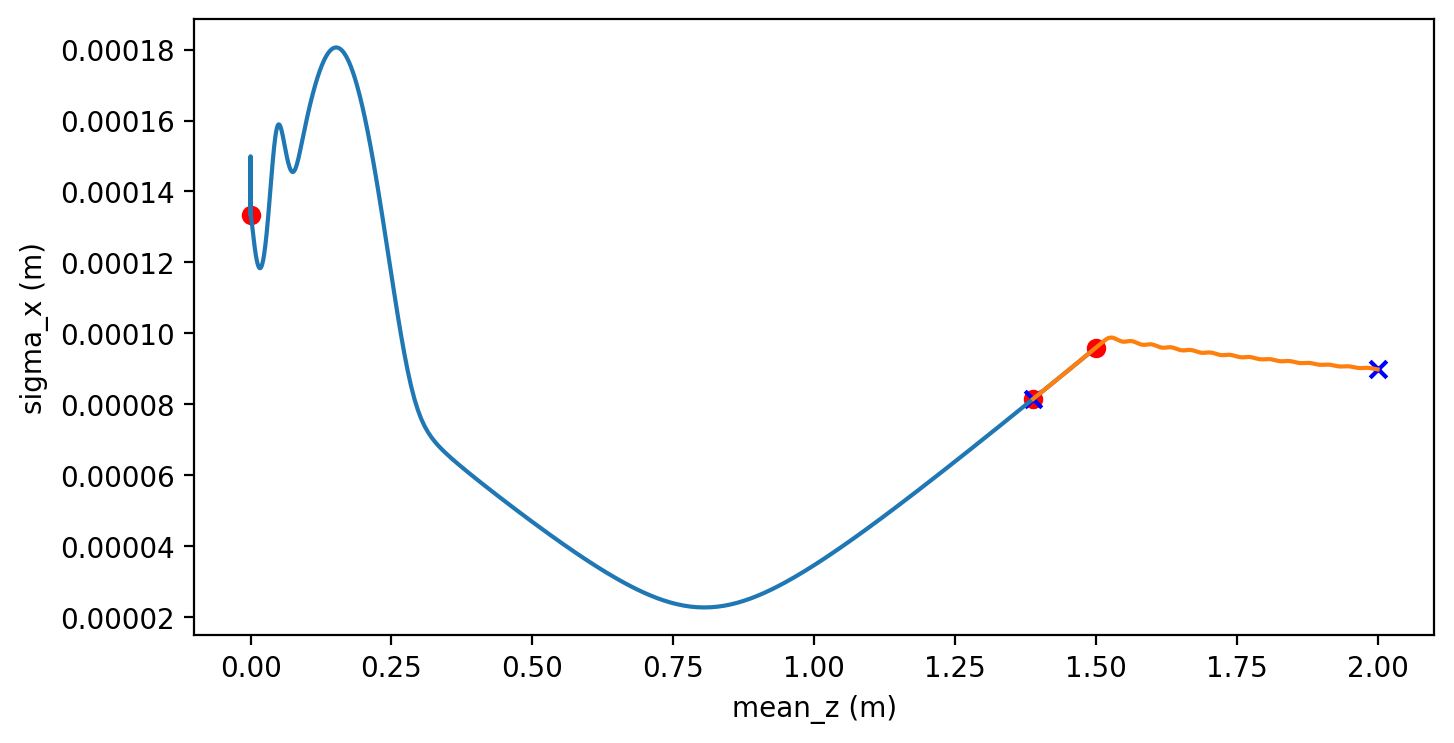

In [27]:

key1 = 'mean_z'
key2 = 'sigma_x'
units1 = str(I.units(key1))
units2 = str(I.units(key2))
plt.xlabel(key1+f' ({units1})')
plt.ylabel(key2+f' ({units2})')
plt.plot(I.stat(key1), I.stat(key2))
plt.plot(I2.stat(key1), I2.stat(key2))
plt.scatter(
    [I.particles[name][key1] for name in I.particles], 
    [I.particles[name][key2] for name in I.particles], color='red')

# Blue X are retracked particles
plt.scatter(
    [P[key1] for P in [Pmid, Pfinal]], 
    [P[key2] for P in [Pmid, Pfinal]], color='blue', marker='x')

# Single particle tracking

Similar to above, but with initial conditions specified in the function for a single particle. 

This is useful for auto-phasing and scaling elements, and tracing reference orbits. 

Space charge is turned off for single particle tracking.

In [28]:
%%time
I3 = I.copy()
I3.verbose=False
I3.configure()
P3 = I3.track1(s=2.2, z0 = 1.0, pz0=10e6)
P3.z, P3.gamma

CPU times: user 21.4 ms, sys: 13.8 ms, total: 35.2 ms
Wall time: 154 ms


(array([2.20002469]), array([1.84584053]))

# Interactive Layout

Plots can be made interctive via [bokeh](https://docs.bokeh.org/en/latest/#)

In [29]:
from bokeh.plotting import output_notebook
from bokeh.plotting import show
output_notebook(hide_banner=True)

from impact.plotting import layout_plot

Change something and plot:

In [30]:
I.ele['QE01']['b1_gradient'] = 0
layout = layout_plot(I.input['lattice'], height=300)
show(layout)

# ControlGroup objects

Some elements need to be changed together, either relatively or absolutely. A single traveling wave cavity, for example, is made from four fieldmaps, with defined relative phases


In [31]:
for name in ['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit']:
     print(name, I[name]['theta0_deg'])

L0A_entrance 264.5
L0A_body_1 294.5
L0A_body_2 354.5
L0A_exit 264.5


Make a copy and add a group to control these. 

In [32]:
I4 = I.copy()
I4.add_group('L0A', ele_names=['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit'], var_name='theta0_deg', attributes='theta0_deg')

ControlGroup(**{"ele_names": ["L0A_entrance", "L0A_body_1", "L0A_body_2", "L0A_exit"], "var_name": "theta0_deg", "attributes": ["theta0_deg", "theta0_deg", "theta0_deg", "theta0_deg"], "factors": [1.0, 1.0, 1.0, 1.0], "reference_values": [264.5, 294.5, 354.5, 264.5], "absolute": false, "value": 0.0, "name": "L0A"})

Make a change

In [33]:
I4['L0A']['theta0_deg'] =0.123456

These get propagated to the underlying elements

In [34]:
for name in I4['L0A'].ele_names:
     print(name, I4[name]['theta0_deg'])

L0A_entrance 264.623456
L0A_body_1 294.623456
L0A_body_2 354.623456
L0A_exit 264.623456


Set overall scaling, respecting the special factors. 

In [35]:
I4.add_group('L0A_scale', ele_names=['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit'],
                   var_name = 'rf_field_scale',
                  factors = [0.86571945106805, 1, 1, 0.86571945106805],  # sin(k*d) with d = 3.5e-2 m 
                  absolute=True)

I4['L0A_scale']['rf_field_scale'] = 10

These get propagated to the underlying elements

In [36]:
for name in I4['L0A_scale'].ele_names:
     print(name, I4[name]['rf_field_scale'])

L0A_entrance 8.657194510680501
L0A_body_1 10.0
L0A_body_2 10.0
L0A_exit 8.657194510680501


# Instantiate from YAML

All of the Impact object init arguments can be passed in a YAML file. Any of:

In [37]:
?Impact

Init signature: Impact(*args, group=None, always_autophase=False, **kwargs)
Docstring:     
Files will be written into a temporary directory within workdir.
If workdir=None, a location will be determined by the system.
File:           ~/Code/GitHub/lume-impact/impact/impact.py
Type:           ABCMeta
Subclasses:     


In [38]:
YAML="""

# Any argument above. One exception is initial_particles: this should be a filename that is parsed into a ParticleGroup

input_file: templates/lcls_injector/ImpactT.in

verbose: True

group:
  L0A:
    ele_names: [ L0A_entrance, L0A_body_1, L0A_body_2, L0A_exit ]
    var_name: dtheta0_deg
    attributes: theta0_deg
    value: 0
    
  L0B:
    ele_names: [ L0B_entrance, L0B_body_1, L0B_body_2, L0B_exit ]
    var_name: dtheta0_deg
    attributes: theta0_deg
    value: 0    
    
  L0A_scale:
    ele_names:  [ L0A_entrance, L0A_body_1, L0A_body_2, L0A_exit ]
    var_name: rf_field_scale
    factors: [0.86571945106805, 1, 1, 0.86571945106805]  # sin(k*d) with d = 3.5e-2 m 
    absolute: True 
    value: 60e6
    
  L0B_scale:
    ele_names:  [ L0B_entrance, L0B_body_1, L0B_body_2, L0B_exit ]
    var_name: rf_field_scale
    factors: [0.86571945106805, 1, 1, 0.86571945106805]  # sin(k*d) with d = 3.5e-2 m 
    absolute: True
    value: 60.0e6
    

"""
I5 = Impact.from_yaml(YAML)
I5['L0A:dtheta0_deg'], I5['L0A_entrance:theta0_deg']

Configured to run in: /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmptalcoik7


(0.0, 264.5)

In [39]:
I5['L0A'].reference_values

[264.5, 294.5, 354.5, 264.5]

In [40]:
I5['L0A']

ControlGroup(**{"ele_names": ["L0A_entrance", "L0A_body_1", "L0A_body_2", "L0A_exit"], "var_name": "dtheta0_deg", "attributes": ["theta0_deg", "theta0_deg", "theta0_deg", "theta0_deg"], "factors": [1.0, 1.0, 1.0, 1.0], "reference_values": [264.5, 294.5, 354.5, 264.5], "absolute": false, "value": 0.0, "name": "L0A"})

# Autophase

Autophase will calculate the relative phases of each rf element by tracking a single particle through the fieldmaps. This is done externally to Impact, and is relatively fast.

A call to `Impact.autophase()` returns the relative phases found as a dict:

In [41]:
I5.autophase()

Found GUN        relative phase = 0.06 deg
Found L0A        relative phase = -4.25 deg


{'GUN': 0.0558822874006637, 'L0A': -4.245356996834516}

You can also give it a dict of `ele_name:rel_phase_deg` with relative phases in degrees, and it will set these as it phases:

In [42]:
I5.autophase({'GUN': -9, 'L0A':2})

Setting GUN relative phase = -9 deg
Found GUN        relative phase = -9.00 deg
Setting L0A relative phase = 2 deg
Found L0A        relative phase = 2.00 deg


{'GUN': -9.0, 'L0A': 2.0}

# Archive all output

All of .input and .output can be archived and loaded from standard h5 files.

Particles are stored in the openPMD-beamphysics format.

Call the `archive` method. If no name is given, a name will be invented based on the fingerprint.

In [43]:
afile = I.archive()

This can be loaded into an empty model

In [44]:
I2 = Impact()
I2.load_archive(afile)

This also works:

In [45]:
I2 = Impact.from_archive(afile)

Check that the fingerprints are the same

In [46]:
assert I.fingerprint() == I2.fingerprint()

Look at a stat, and compare with the original object

In [47]:
I.stat('norm_emit_x')[-1], I2.stat('norm_emit_x')[-1]

(3.5584349e-08, 3.5584349e-08)

The particles look the same:

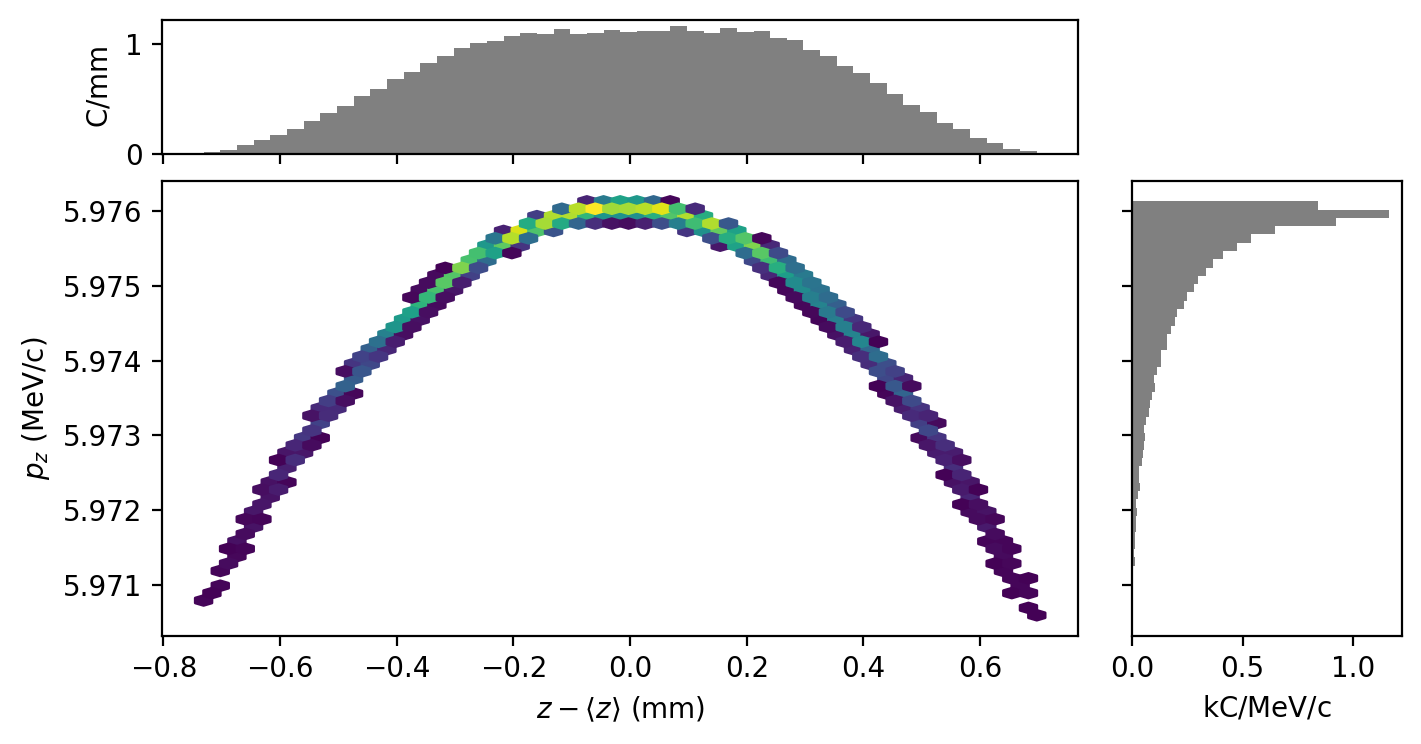

In [48]:
I2.particles['final_particles'].plot('delta_z', 'pz')

# Cleanup

In [49]:
os.remove(afile)